Scattering of swell by currents

In this notebook, we compute the wave action spectrum and significant wave height resulting from interactions between a swell-like incoming wave with a localized current, using the matched asymptotics approach described in the paper.

In [1]:
import numpy as np
import colorcet as cc
import matplotlib.pyplot as plt
import sympy 
from scipy import integrate
from IPython.display import Markdown, display

def round_to_sig_figs(x, sig_figs):
    if x == 0:
        return 0
    else:
        return round(x, sig_figs - int(sympy.floor(sympy.log(abs(x), 10))) - 1)

def round_expr(expr, num_digits):
    if expr.is_Number:
        return round_to_sig_figs(expr, num_digits)
    elif expr.is_Symbol:
        return expr
    else:
        return expr.func(*[round_expr(arg, num_digits) for arg in expr.args])
    
pi=np.pi

In [2]:
#Grid in theta, the polar angle of wavenumebrs. 
#You may need to increase Ntheta if the wave action spectra is more narrow-banded than the default setting.
Ntheta = 64 
theta = np.linspace(-pi/2,pi/2,Ntheta)
dtheta = theta[1]-theta[0]

#Grid in x,y, the locations in real space
rv = 25000 #radius of scattering region, where vorticity is significant. 
Nx = 201
x1d = np.linspace(-10,30,Nx)*rv 
Ny = 161
y1d = np.linspace(-16,16,Ny)*rv
x2d, y2d = np.meshgrid(x1d,y1d)
x2d = np.transpose(x2d) #Make indexing intuitive, i.e. F[i,j] would mean we want q1 at the ith and q2 at the jth.
y2d = np.transpose(y2d)

### Define the current vorticity Z

The matched asymptotics approach requires that $Z$ is negligible outside the radius $r_v$, which can be checked visually in the figure generated below. In the default setup here, we define $Z$ as the Gaussian vortex with $U_m=0.8\ \text{m/s}$.

You can vary parameters such as $U_m$ or $r_v$ to get a different Gaussian vortex, or you can change the form of Z completely. 

In [3]:
# Define parameters for Gaussian vortex
Um = 0.8 #maximum velocity for the Gaussian vortex
# Define symbols
x, y, x1 = sympy.symbols('x y x1')
# Compute circulation for Gaussian vortex
Kappa = Um*rv/0.072 
# Define vorticity
Z = Kappa/(2*pi*rv**2)*sympy.exp(-sympy.sqrt(x**2+y**2)**2/(2*rv**2))

<span style="font-size: 15px;">The expression for vorticity is $Z=7.07 \cdot 10^{-5} e^{- 8.0 \cdot 10^{-10} x^{2} - 8.0 \cdot 10^{-10} y^{2}}$.</span>

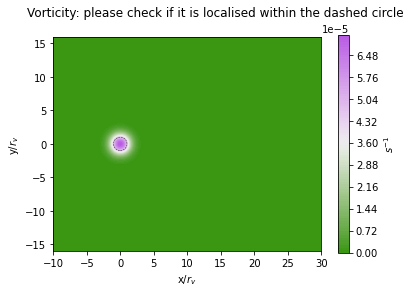

In [4]:
# Display the expression for vorticity
rounded_Z = round_expr(Z, 3)
font_size = 15
display(Markdown(f'<span style="font-size: {font_size}px;">The expression for vorticity is $Z={sympy.latex(rounded_Z)}$.</span>'))

#Plot Z to visually check that the vorticity is localized within rv
Zlamb = sympy.lambdify((x,y),Z, 'numpy')
figZ,axZ = plt.subplots()
#figZ.set_dpi(256)
imZ = axZ.contourf(x1d/rv,y1d/rv,np.transpose(Zlamb(x2d,y2d)),100,cmap = cc.cm.gwv)
vortradius = plt.Circle((0, 0), 1,edgecolor = '#221D1D', linestyle = '--',linewidth = 0.5,fill = False)
axZ.add_patch(vortradius)
axZ.set_aspect('equal')
figZ.suptitle('Vorticity: please check if it is localised within the dashed circle')
axZ.set_ylabel(r'y/$r_{\mathit{v}}$')
axZ.set_xlabel(r'x/$r_{\mathit{v}}$')
cbar = plt.colorbar(imZ)
cbar.set_label(r'$s^{-1}$')

### Define the directional dependence $D_{\star}(\theta)$

In the default form, $D_{\star}(\theta)$ is a Gaussian, consistent with the Longuet-Higgins et al. ("LHCS") model at large $s$. You can uncomment the line after the present definition of $D$ in the code, in order to define $D_{\star}(\theta)$ as the higher power of a cosine function, which agrees strictly with the LHCS definition. The resulting wave action spectra and significant wave height should not change significantly as long as $s$ is reasonably large (at, say, $s=10$, which is about the bare minimum for swells under the LHCS model.)

You can play with different values of $s$ to see how the significant wave height changes accordingly. As explained in the paper, you should be able to see the emergence of caustics at very large $s$. Please note that if you take $s$ to be very large (say, $s=10000$), in order to resolve the angular dependence, you may need to refine the grid in the wavenumber angle $\theta$ by increasing "Ntheta". Please note that smaller $s$ leads to larger directional spreading $\delta$, which would deviate more from the assumption of small $\delta$ made in the matched asymptotics apporach.

You can also try different forms of $D_{\star}(\theta)$. Similar to the LHCS case, the more narrow-banded it is in $\theta$, the better it would satisfy the assumption of small directional spreading; however, if it's too narrow-banded, you may need to increase "Ntheta". 

We do not need to prescribe the wavenumber dependence $F_{\star}(k)$ here, as the wavenumber dependence is constructed to normalize to $1$ after integration over $k$, and doesn't affect the overall magnitudes of wave action after integration over $k$. 

In [5]:
# Wave action spectrum
# Customizable parameters
s = 40 # Parameter in the LHCS model. Larger s leads to narrower directional spreading.
theta_p = 0 # Peak of the wavenumber angle
fp = 1/10.3 # Peak frequency (unit 1/s); note that it is not angular frequency, but 1/period.
g = 9.806 # Gravitational acceleration

# Angular dependence of wave action
D = lambda theta: np.exp(-s*(theta-theta_p)**2/4)
# D = lambda theta: np.cos((theta-theta_p)/2)**(2*s)

### Compute the matched asymptotics solution of wave action

In the following code cell, we compute the matched asymptotics solution of wave action and plot the integrated wave action spectrum $\int A(x,y,k,\theta)dk$ at different locations in $x$. 

As explained in the paper, the changes in wave action with respect to the incoming waves can be explained by the ray curvature deflection induced by the current vorticity. In the computation, we will evaluate these two integrations, which reflect cumulative ray curvature deflections, and show up in the matched asymptotics expressions in the paper:

$\Delta (y) = \frac{1}{c_{\star}}\int_{-\infty}^{\infty} Z(x',y)\,\mathrm{d}x'$, 

and 

$\Omega (x,y)= \frac{1}{c_{\star}}\int_{-\infty}^{x} Z(x',y)\,\mathrm{d}x'$.

If you set the variable "integrable" as 1, the code will (attempt to) compute the integrations $\Delta(y)$ and $\Omega (x,y)$ symbolically using the sympy package. The code may crash if analytical expressions for them don't exist, or are hard to find. 

In that case, you should set the variable "integrable" as 0. The code will then evaluate the integrations numerically. The downside of this is that the code may then take a long time to run, as the integration will be evaluated at every point in $x,y,\theta$ in this code. 

In [6]:
integrable = 1 # Set to be 1 if Z is integrable and both deflection terms (introduced in the markdown cell above) have analytic expressions. Otherwise, set to be 0.
    #Note that analytic expressions are integrated through sympy here. Sympy might not always be able to integrate even if theoretically the analytical expressions exist. In that case, you'd set integrable=0.)


<span style="font-size: 15px;">The analytic expression for deflection is $\Delta=0.311 \pi^{0.5} e^{- 8.0 \cdot 10^{-10} y^{2}}$.</span>

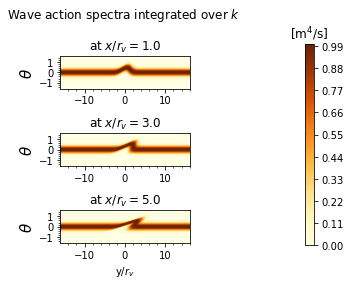

In [7]:
kp = (2*pi*fp)**2/g #peak of wavenumber magnitude
cpinv = (np.sqrt(g*kp)/kp)**(-1)*2#c_*^{-1}, inverse of group velocity corresponding to peak wavenumber
if integrable == 1: #Compute the deflection terms using symbolic operator 
    Deltasp = sympy.integrate(Z, (x, -sympy.oo, sympy.oo)) * cpinv
    Omegasp=sympy.integrate(Z,(x,-sympy.oo,x1))*cpinv
    Delta = sympy.lambdify(y, Deltasp, 'numpy')
    Omega = sympy.lambdify((x1, y), Omegasp, 'numpy') 
elif integrable == 0: #Compute the deflection terms using numerical integration (quadrature). 
    #Note that we take 10*rv as infinity in the integration limits, which is a good approximation provided that the vorticity indeed decays quickly outside rv. 
    #This method is likely to be significantly slower than the symbolic operator, as it has to do the integration at every inquiry point.
    Delta = lambda y : integrate.quad(Zlamb,-10*rv,10*rv,args=(y,))[0]*cpinv  
    Omega = lambda x,y : integrate.quad(Zlamb,-10*rv,x,args=(y,))[0]*cpinv  
else:
    raise ValueError('Please specify if the vorticity is integrable by setting "integrable" as either 1 or 0.')
# Define incoming wave action integrated over k. 
A_in = lambda theta: D(theta)

# Mathced aymptotics solution of wave action 
A_uniform = lambda x,y,Theta: A_in(Theta-Omega(x,y-x*Theta))

#Display the expression of deflection
if integrable == 1:
    rounded_Delta = round_expr(Deltasp, 3)   
    font_size = 15
    display(Markdown(f'<span style="font-size: {font_size}px;">The analytic expression for deflection is $\Delta={sympy.latex(rounded_Delta)}$.</span>'))
else:
    display(Markdown('The deflection $\Delta$ will be computed numerically. It may take a while to run.'))
#Compute and plot cross sections of integrated wave action
xslice_all = np.sort([1*rv,3*rv,5*rv])  #Locations to plot cross sections; can be modified
nslices = len(xslice_all)

figAxs,axAxs = plt.subplots(nslices)
#figAxs.set_dpi(256)   
islice = -1
for xslice in xslice_all:
    A_xslice = np.zeros([Ntheta,Ny])
    islice = islice+1
    
    # Compute integrated wave action
    for iy in np.arange(Ny):
        for itheta in np.arange(Ntheta):
            A_xslice[itheta,iy] = A_uniform(xslice,y1d[iy],theta[itheta])    
    ifigtheta = np.arange(Ntheta) #Can cut ifigtheta into a smaller range, if you want less indices of theta to be shown in the figure. 
    cmapmax = np.nanmax(A_xslice)
    cmapmin = np.nanmin(A_xslice)
    imAxs = axAxs[islice].contourf(y1d/rv,theta[ifigtheta],(A_xslice[ifigtheta,:]),100,cmap='YlOrBr',vmax=cmapmax,vmin=cmapmin)#Checked that if not transposed, there will be bug when nq1!=nq2. 

    axAxs[islice].minorticks_on()
    axAxs[islice].set_title(r'at $x/r_{\mathit{v}}=%1.1f$' % (xslice/rv)) 
    axAxs[islice].set_ylabel(r'$\theta$',fontsize = 15)
    axAxs[islice].tick_params(labelbottom=False)       
    #set aspect ratio of figure panel
    asratio = 0.25
    x_left, x_right = axAxs[islice].get_xlim()
    y_low, y_high = axAxs[islice].get_ylim()
    axAxs[islice].set_aspect(abs((x_right-x_left)/(y_low-y_high))*asratio)
    axAxs[islice].tick_params(labelbottom=True)    
figAxs.suptitle(r'Wave action spectra integrated over $k$')
axAxs[islice].set_xlabel(r'y/$r_{\mathit{v}}$')
plt.tight_layout()
cbar_ax = figAxs.add_axes([0.92, 0.15, 0.02, 0.7]) #Tuple (left, bottom, width, height).
cbar_ax.set_title(r'$[\mathrm{m}^4 \mathrm{/s}]$')
cbar = plt.colorbar(imAxs,cax=cbar_ax)

In the next cell, we compute the significant wave height follwing the matched asymptotics approach. 

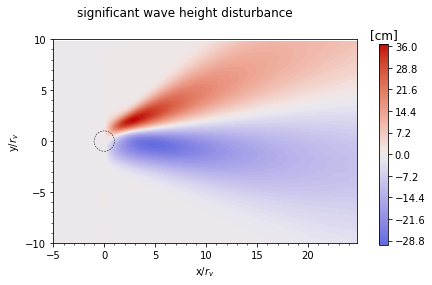

In [8]:
# Significant wave height calculation

# Set the average significant wave height at the undisturbed state (default is 1 meter)
hs_ave=1

# Initialize array for the square of significant wave height
hssq = np.zeros(x2d.shape)

# Compute the square of significant wave height at each grid point
if integrable == 1:
    for i in range(Nx):
        for j in range(Ny):
            # Integrate wave action over theta to get wave action spectrum at each point
            A_at_point = A_in(theta-Delta(y1d[j]-x1d[i]*theta)*np.heaviside(x1d[i], 1))
            # Compute the square of significant wave height at the point
            hssq[i,j] = sum(A_at_point)*dtheta
else:
    #The logic is the same as the case when integrable = 1, but we have some small hacks to help save a bit of computational time
    for i in range(Nx):
        if x1d[i] > 0: #equivalent to np.heaviside(x1d[i], 1)
            for j in range(Ny):
                A_at_point=0
                for thetai in theta:
                    A_at_point = A_at_point+A_in(thetai-Delta(y1d[j]-x1d[i]*thetai))
                    hssq[i,j] = A_at_point*dtheta    
        else: 
            A_at_point = A_in(theta)
            hssq[i,:] = sum(A_at_point)*dtheta

# Compute significant wave height as the square root of the wave height squared               
hs = np.sqrt(hssq)

# Compute normalization factor to make the average significant wave height equal to hs_ave
A_zeroZ = lambda Theta: A_in(Theta)
hs_zeroZ = np.sqrt(sum(A_zeroZ(theta))*dtheta)
hs = hs/hs_zeroZ*hs_ave-hs_ave 

# Plot significant wave height disturbance
fighszoom,axhszoom = plt.subplots()
#fighszoom.set_dpi(256)

# Set the zoom window to focus on the region around the vortex
ymax = 10*rv
ymin = -10*rv
xmax = 25*rv
xmin = -5*rv
# Compute the indices of the x and y coordinates that correspond to the zoom window
ixstart = np.absolute(x1d-xmin).argmin()
ixend = np.absolute(x1d-xmax).argmin()
iystart = np.absolute(y1d-ymin).argmin()
iyend = np.absolute(y1d-ymax).argmin()
# Extract the significant wave height data within the zoom window
hszoom = hs[ixstart:ixend,iystart:iyend]

# Set the maximum and minimum values of the color map
cmapmax = np.max([np.nanmax(hszoom*100),-np.nanmin(hszoom*100)]) 
cmapmin = -cmapmax
# Plot the significant wave height disturbance
imhszoom = axhszoom.contourf(x1d[ixstart:ixend]/rv,y1d[iystart:iyend]/rv,np.transpose(hszoom)*100,100,cmap=cc.cm.coolwarm,vmax=cmapmax,vmin=cmapmin)
# Add dashed circle marking the boundary of the scattering region
vortradius2 = plt.Circle((0, 0), 1,edgecolor = '#221D1D', linestyle = '--',linewidth = 0.5,fill = False)
axhszoom.add_patch(vortradius2)
# Set axis labels and aspect ratio
axhszoom.set_ylabel(r'y/$r_{\mathit{v}}$')
axhszoom.set_xlabel(r'x/$r_{\mathit{v}}$')
axhszoom.set_aspect('equal')
# Set minor ticks and y tick locations
axhszoom.minorticks_on()
axhszoom.set_yticks(ticks = [-10,-5,0,5,10])
# Add title and colorbar
fighszoom.suptitle('significant wave height disturbance')
plt.tight_layout()
cbar_ax = fighszoom.add_axes([0.95, 0.15, 0.02, 0.7])  # Tuple (left, bottom, width, height).
cbar_ax.set_title('[cm]')
cbar = plt.colorbar(imhszoom, cax=cbar_ax)